In [14]:
%reload_ext autoreload
%autoreload 2

import os
import io
import pickle
import sys
import datetime
from re import match
import json
from time import strftime, gmtime

import boto3
import sagemaker
from sagemaker.tensorflow.estimator import TensorFlow
from sagemaker.tensorflow import TensorFlowModel
from sagemaker.tuner import ContinuousParameter, IntegerParameter, CategoricalParameter, HyperparameterTuner
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import numpy as np
import pandas as pd
from hydra import compose, initialize, core
from omegaconf import OmegaConf

import matplotlib.pyplot as plt

sys.path.append(os.path.dirname(os.getcwd()))
from src import custom_utils

## Hydra

In [2]:
# Reset global config https://github.com/facebookresearch/hydra/blob/0.11_branch/hydra/_internal/hydra.py#L41-L42
core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base='1.2', config_path='../src/config', job_name='baseline_fine_tune_notebook')
config = OmegaConf.to_container(compose(config_name='main'), resolve=True)
# Group configs
baseline_config = config['baseline']
fine_tune_config = config['fine_tune']

## S3

In [3]:
s3 = boto3.client('s3')

train_val_path = {
    'train': sagemaker.inputs.TrainingInput(
        s3_data=f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/train',
        distribution='FullyReplicated',
        s3_data_type='S3Prefix'
    ),
    'val': sagemaker.inputs.TrainingInput(
        s3_data=f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/val',
        distribution='FullyReplicated',
        s3_data_type='S3Prefix'
    )
}
train_val_path

{'train': <sagemaker.inputs.TrainingInput at 0x7f4b34ee2560>,
 'val': <sagemaker.inputs.TrainingInput at 0x7f4c041696c0>}

## Sagemaker

In [4]:
sagemaker_session = sagemaker.Session(default_bucket=config["s3_bucket"])
sagemaker_session

sm_boto3 = boto3.client('sagemaker')
role = sagemaker.get_execution_role()

## Baseline

### Tensorflow Estimator

In [5]:
baseline_tf_estimator = TensorFlow(
    role='role',
    instance_type='local',
    hyperparameters={'local_test_mode': 1},
    # Global config
    source_dir=config['src_dir_path'],
    py_version=config['py_version'],
    framework_version=config['framework_version'],
    model_dir=config['model_dir'],
    code_location=config['code_location'],
    # Group config
    entry_point=baseline_config['entry_point'],
    instance_count=baseline_config['instance_count']
)
baseline_tf_estimator

Testing training script locally:

In [6]:
# In case the /tmp directory runs out of space (i.e. code below returns device out of space error) during local training (local training uses /tmp for storage)
!sudo rm -rf /tmp/tmp*

In [7]:
# Generate random hyperparameters for testing
baseline_testing_hyperparameters = {
    'random_contrast_factor': 0.1,
    'random_flip_mode': 'horizontal',
    'random_rotation_factor': 0.1,
    'random_zoom_height_factor': 0.1,
    'random_zoom_width_factor': 0.1,
    'conv2d_filters_1': 32,
    'conv2d_filters_2': 32,
    'conv2d_filters_3': 32,
    'conv2d_filters_4': 32,
    'conv2d_filters_5': 32,
    'conv2d_weight_decay': 1e-6,
    'conv2d_batch_norm_momentum': 0.6,
    'dense_units_1': 128,
    'dense_units_2': 128,
    'dense_batch_norm_momentum': 0.6,
    'dense_weight_decay': 1e-6,
    'dropout_rate': 0.8,
    'sgd_initial_lr': 0.01,
    'sgd_lr_decay_steps': 1000,
    'sgd_lr_decay_rate': 0.9,
    'sgd_momentum': 0.9,
    'sgd_clipnorm': 1.0,
    'batch_size': 512,
    'epochs': 2,
    'use_sample_weights': 1
}

baseline_tf_estimator.set_hyperparameters(**baseline_testing_hyperparameters)

baseline_tf_estimator.fit(train_val_path)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2023-06-26-15-59-56-279
INFO:sagemaker.local.local_session:Starting training job
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.local.image:No AWS credentials found in session but credentials from EC2 Metadata Service are available.
INFO:sagemaker.local.image:docker compose file: 
networks:
  sagemaker-local:
    name: sagemaker-local
services:
  algo-1-1se60:
    command: train
    container_name: cwezmvicey-algo-1-1se60
    environment:
    - '[Masked]'
    - '[Masked]'
    image: 763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-training:2.8-cpu-py39
    networks:
      sagemaker-local:
        aliases:
        - algo-1-1se60
    stdin_open: true
    tty: true
    volumes:
    - /tmp/tmpuui1l_qg/algo-1-1se60/output:/opt/ml/output
    - 

Login Succeeded


INFO:sagemaker.local.image:image pulled: 763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-training:2.8-cpu-py39


Creating cwezmvicey-algo-1-1se60 ... 
Creating cwezmvicey-algo-1-1se60 ... done
Attaching to cwezmvicey-algo-1-1se60
cwezmvicey-algo-1-1se60 | 2023-06-26 16:02:30.957152: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
cwezmvicey-algo-1-1se60 | 2023-06-26 16:02:30.957335: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
cwezmvicey-algo-1-1se60 | 2023-06-26 16:02:30.991752: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
cwezmvicey-algo-1-1se60 | 2023-06-26 16:02:33,507 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
cwezmvicey-algo-1-1se60 | 2023-06-26 16:02:33,526 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
cwezmvicey-algo-1-1se60 | 2023-06-26 16:02:33,537 sage

INFO:root:creating /tmp/tmpuui1l_qg/artifacts/output/data
INFO:root:copying /tmp/tmpuui1l_qg/algo-1-1se60/output/success -> /tmp/tmpuui1l_qg/artifacts/output
INFO:root:creating /tmp/tmpuui1l_qg/artifacts/model/00000000
INFO:root:creating /tmp/tmpuui1l_qg/artifacts/model/00000000/variables
INFO:root:copying /tmp/tmpuui1l_qg/model/00000000/variables/variables.data-00000-of-00001 -> /tmp/tmpuui1l_qg/artifacts/model/00000000/variables
INFO:root:copying /tmp/tmpuui1l_qg/model/00000000/variables/variables.index -> /tmp/tmpuui1l_qg/artifacts/model/00000000/variables
INFO:root:creating /tmp/tmpuui1l_qg/artifacts/model/00000000/assets
INFO:root:copying /tmp/tmpuui1l_qg/model/00000000/saved_model.pb -> /tmp/tmpuui1l_qg/artifacts/model/00000000
INFO:root:copying /tmp/tmpuui1l_qg/model/00000000/keras_metadata.pb -> /tmp/tmpuui1l_qg/artifacts/model/00000000


===== Job Complete =====


Reinstantiate baseline estimator for tuning job:

In [8]:
baseline_tf_estimator = TensorFlow(
    role=role,
    sagemaker_session=sagemaker_session,
    hyperparameters={'local_test_mode': 0},
    output_path=config['output_path'],
    volume_size=config['volume_size'],
    # Global config
    source_dir=config['src_dir_path'],
    py_version=config['py_version'],
    framework_version=config['framework_version'],
    model_dir=config['model_dir'],
    code_location=config['code_location'],
    # Spot training
    checkpoint_s3_uri=config['checkpoint_s3_uri'],
    max_retry_attempts=config['max_retry_attempts'],
    use_spot_instances=config['use_spot_instances'],
    max_wait=config['max_run'],
    max_run=config['max_run'],
    # Group config
    entry_point=baseline_config['entry_point'],
    instance_count=baseline_config['instance_count'],
    instance_type=baseline_config['instance_type'],
    base_job_name=baseline_config['base_job_name']
)
baseline_tf_estimator

### Hyperparameter Optimization

In [9]:
baseline_search_space = {
    # Data augmentation parameters
    'random_contrast_factor': ContinuousParameter(min_value=0.1, max_value=1.0),
    'random_flip_mode': CategoricalParameter(values=['horizontal', 'vertical', 'horizontal_and_vertical']),
    'random_rotation_factor': ContinuousParameter(min_value=0.1, max_value=0.7),
    'random_zoom_height_factor': ContinuousParameter(min_value=0.1, max_value=0.7),
    'random_zoom_width_factor': ContinuousParameter(min_value=0.1, max_value=0.7),
    # Conv2D parameters with increasing number of filters
    'conv2d_filters_1': IntegerParameter(min_value=32, max_value=128),
    'conv2d_filters_2': IntegerParameter(min_value=64, max_value=128),
    'conv2d_filters_3': IntegerParameter(min_value=64, max_value=128),
    'conv2d_filters_4': IntegerParameter(min_value=128, max_value=256),
    'conv2d_filters_5': IntegerParameter(min_value=128, max_value=256),
    'conv2d_weight_decay': ContinuousParameter(min_value=1e-6, max_value=1e-2, scaling_type='Logarithmic'),
    'conv2d_batch_norm_momentum': ContinuousParameter(min_value=0.8, max_value=0.99),
    # Dense parameters
    'dense_units_1': IntegerParameter(min_value=32, max_value=256),
    'dense_units_2': IntegerParameter(min_value=32, max_value=256),
    'dense_batch_norm_momentum': ContinuousParameter(min_value=0.8, max_value=0.99),
    'dense_weight_decay': ContinuousParameter(min_value=1e-6, max_value=1e-2, scaling_type='Logarithmic'),
    'dropout_rate': ContinuousParameter(min_value=0.0, max_value=0.5),
    # Optimization and fit parameters
    'sgd_initial_lr': ContinuousParameter(min_value=1e-4, max_value=1e-2),
    'sgd_lr_decay_steps': IntegerParameter(min_value=100, max_value=10000),
    'sgd_lr_decay_rate': ContinuousParameter(min_value=0.1, max_value=0.9),
    'sgd_momentum': ContinuousParameter(min_value=0.0, max_value=0.8),
    'sgd_clipnorm': ContinuousParameter(min_value=0.5, max_value=1.0),
    'batch_size': CategoricalParameter(values=[64, 128, 256]),
    'epochs': IntegerParameter(min_value=10, max_value=20),
    'use_sample_weights': CategoricalParameter(values=[0, 1])
}

baseline_objective_metric_name = 'accuracy'
baseline_objective_type = 'Maximize'
baseline_metric_definitions = [
    {
        'Name': baseline_objective_metric_name,
        'Regex': 'Best validation accuracy: ([0-9\\.]+)',
    }
]

In [10]:
baseline_hpo_tuner = HyperparameterTuner(
    estimator=baseline_tf_estimator,
    objective_metric_name=baseline_objective_metric_name,
    hyperparameter_ranges=baseline_search_space,
    metric_definitions=baseline_metric_definitions,
    strategy='Bayesian',
    objective_type=baseline_objective_type,
    max_jobs=10,
    max_parallel_jobs=5,
    base_tuning_job_name=baseline_config['base_tuning_job_name']
)

In [11]:
baseline_hpo_tuner.fit(train_val_path)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: baseline-hpo-230626-1608


Using provided s3_resource
..

Results of optimization:

In [11]:
baseline_hpo_analytics = sagemaker.HyperparameterTuningJobAnalytics(baseline_hpo_tuner.latest_tuning_job.name)

baseline_hpo_results = baseline_hpo_analytics.dataframe()

baseline_hpo_results.sort_values('FinalObjectiveValue', ascending=False).head(10)

batch_size  conv2d_batch_norm_momentum  conv2d_filters_1  conv2d_filters_2  \
0      "128"                    0.844583              43.0              94.0   
8       "64"                    0.913676              59.0              90.0   
7      "128"                    0.835045              39.0              93.0   
1       "64"                    0.910443              50.0              90.0   
5      "256"                    0.877068              85.0              81.0   
2      "256"                    0.871926             124.0             117.0   
4      "256"                    0.831942              41.0              89.0   
9       "64"                    0.824786              59.0              88.0   
6      "128"                    0.960494             110.0              66.0   
3      "256"                    0.830966              51.0              82.0   

   conv2d_filters_3  conv2d_filters_4  conv2d_filters_5  conv2d_weight_decay  \
0              85.0             162.0             202.0             0.002988   
8              90.0             189.0             144.0             0.000525   
7              88.0             159.0             212.0             0.007964   
1              91.0             181.0             146.0             0.000979   
5              93.0             131.0             232.0             0.000060   
2             103.0             138.0             129.0             0.000088   
4             128.0             209.0             137.0             0.000178   
9              80.0             242.0             224.0             0.001349   
6              96.0             227.0             128.0             0.000094   
3              95.0             154.0             240.0             0.001289   

   dense_batch_norm_momentum  dense_units_1  ...  sgd_lr_decay_rate  \
0                   0.945845           61.0  ...           0.679072   
8                   0.817362          128.0  ...           0.205626   
7                   0.974285           52.0  ...           0.756857   
1                   0.827984          105.0  ...           0.249672   
5                   0.983460          144.0  ...           0.490422   
2                   0.964222          121.0  ...           0.791180   
4                   0.836558           42.0  ...           0.518655   
9                   0.979945          183.0  ...           0.516251   
6                   0.972525          238.0  ...           0.646482   
3                   0.840353           62.0  ...           0.629514   

   sgd_lr_decay_steps  sgd_momentum  use_sample_weights  \
0               275.0      0.597204                 "0"   
8              2928.0      0.656827                 "1"   
7               169.0      0.576983                 "0"   
1              1347.0      0.679913                 "1"   
5              7009.0      0.542374                 "1"   
2              2770.0      0.054356                 "0"   
4              1774.0      0.191913                 "1"   
9              4056.0      0.777571                 "1"   
6               412.0      0.250188                 "1"   
3              2228.0      0.259713                 "0"   

                         TrainingJobName TrainingJobStatus  \
0  baseline-hpo-230613-1412-010-d0a27909         Completed   
8  baseline-hpo-230613-1412-002-957099ac         Completed   
7  baseline-hpo-230613-1412-003-3ac7d4e5         Completed   
1  baseline-hpo-230613-1412-009-0dcc0ca6         Completed   
5  baseline-hpo-230613-1412-005-b328638b         Completed   
2  baseline-hpo-230613-1412-008-d0b939c7         Completed   
4  baseline-hpo-230613-1412-006-83464777         Completed   
9  baseline-hpo-230613-1412-001-a6060169         Completed   
6  baseline-hpo-230613-1412-004-f81ba5ee         Completed   
3  baseline-hpo-230613-1412-007-96de57fb         Completed   

   FinalObjectiveValue         TrainingStartTime           TrainingEndTime  \
0             0.373528 2023-06-13 14:56:03+00:0

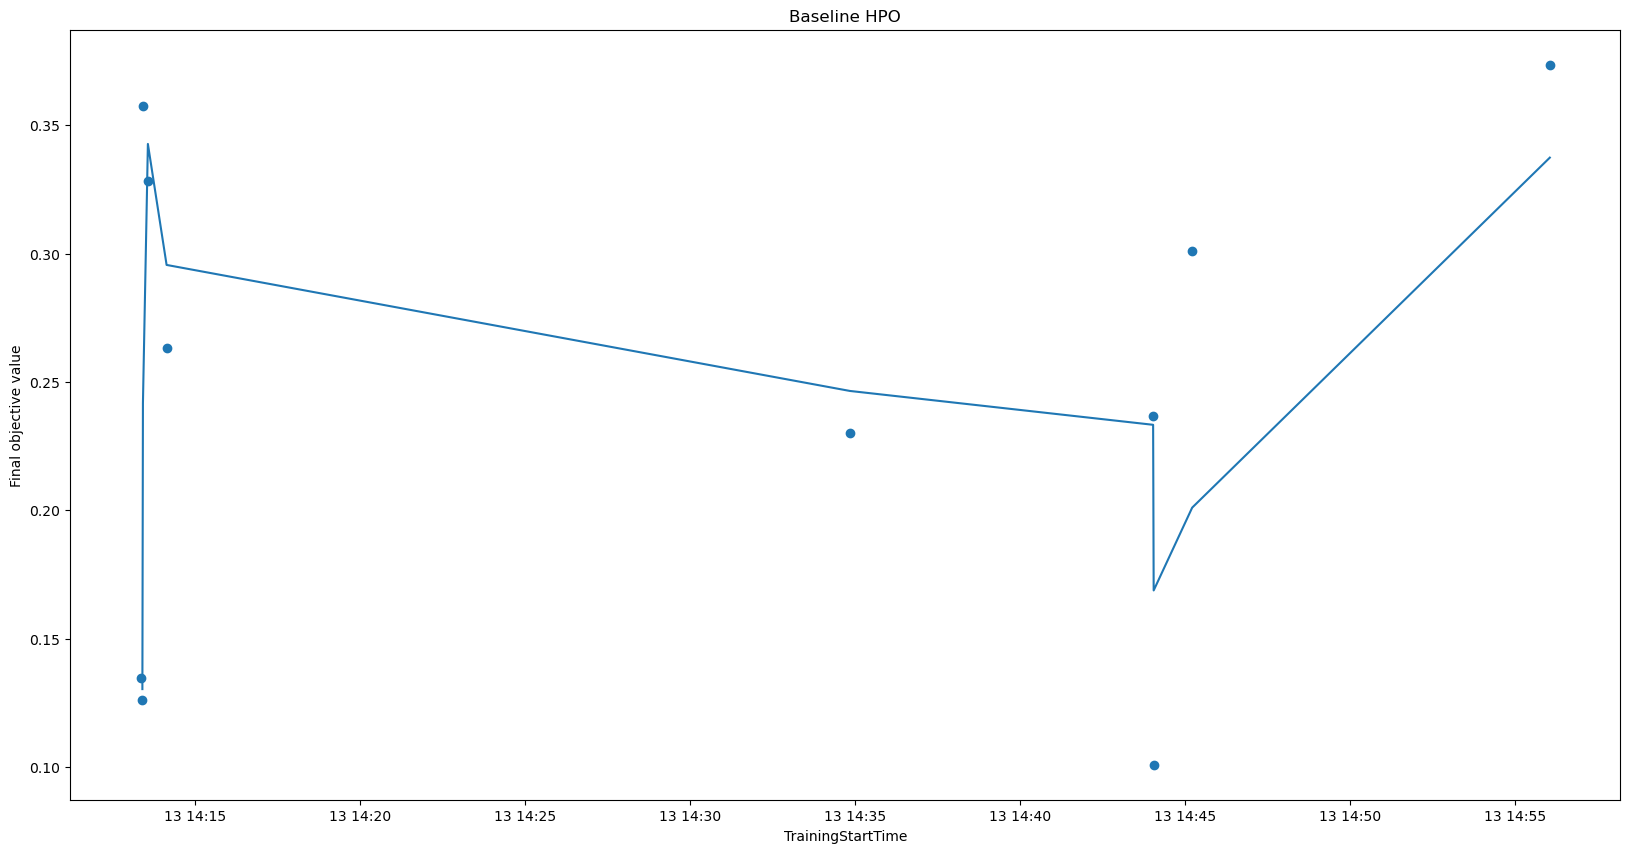

In [12]:
plt.figure(figsize=(20, 10))
# Remove missing values in TrainingStartTime
baseline_hpo_results = baseline_hpo_results[baseline_hpo_results['TrainingStartTime'].notna()]
# Sort by TrainingStartTime
baseline_hpo_results.sort_values('TrainingStartTime', inplace=True)
plt.scatter(baseline_hpo_results['TrainingStartTime'], baseline_hpo_results['FinalObjectiveValue'])
plt.plot(baseline_hpo_results['TrainingStartTime'], baseline_hpo_results['FinalObjectiveValue'].rolling(2).mean())
plt.xlabel('TrainingStartTime')
plt.ylabel('Final objective value')
plt.title('Baseline HPO')
plt.show();

## Fine-Tuning

### Tensorflow Estimator

Test fine-tuning script locally:

In [11]:
!sudo rm -rf /tmp/tmp*

In [12]:
fine_tune_testing_hyperparameters = {}
fine_tune_testing_estimators = {}
for pretrained_name in ['vgg19', 'resnet50v2', 'xception']:

    fine_tune_testing_estimators[pretrained_name] = TensorFlow(
        role=role,
        instance_type='local',
        hyperparameters={'local_test_mode': 1},
        # Global config
        source_dir=config['src_dir_path'],
        py_version=config['py_version'],
        framework_version=config['framework_version'],
        model_dir=config['model_dir'],
        code_location=config['code_location'],
        # Group config
        entry_point=fine_tune_config['entry_point'],
        instance_count=fine_tune_config['instance_count']
    )

    fine_tune_testing_hyperparameters[pretrained_name] = {
        # Data augmentation parameters
        'random_flip_mode': 'horizontal',
        'random_rotation_factor': 0.15,
        'random_contrast_factor': 0.15,
        'random_zoom_height_factor': 0.15,
        'random_zoom_width_factor': 0.15,
        # Architecture parameters
        'dense_units_1': 32,
        'dense_units_2': 32,
        'dense_units_3': 32,
        'dense_weight_decay': 1e-4,
        'dense_batch_norm_momentum': 0.9,
        'dropout_rate': 0.2,
        # Optimization and fit parameters
        'adam_initial_lr': 1e-4,
        'adam_lr_decay_steps': 1000,
        'adam_lr_decay_rate': 0.9,
        'adam_beta_1': 0.9,
        'adam_beta_2': 0.999,
        'adam_clipnorm': 1.0,
        'batch_size': 512,
        'epochs': 2,
        'use_sample_weights': 1,
        # Pretraining parameters
        'pretrained_name': pretrained_name,
        'pretrained_pooling': 'avg'        
    }

In [13]:
fine_tune_testing_estimators['vgg19'].set_hyperparameters(**fine_tune_testing_hyperparameters['vgg19'])

fine_tune_testing_estimators['vgg19'].fit(train_val_path)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2023-06-22-17-59-25-111
INFO:sagemaker.local.local_session:Starting training job
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.local.image:No AWS credentials found in session but credentials from EC2 Metadata Service are available.
INFO:sagemaker.local.image:docker compose file: 
networks:
  sagemaker-local:
    name: sagemaker-local
services:
  algo-1-klytw:
    command: train
    container_name: jwhs71bic0-algo-1-klytw
    environment:
    - '[Masked]'
    - '[Masked]'
    image: 763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-tr

Creating jwhs71bic0-algo-1-klytw ... 
Creating jwhs71bic0-algo-1-klytw ... done
Attaching to jwhs71bic0-algo-1-klytw
jwhs71bic0-algo-1-klytw | 2023-06-22 18:00:05.651093: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
jwhs71bic0-algo-1-klytw | 2023-06-22 18:00:05.651280: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
jwhs71bic0-algo-1-klytw | 2023-06-22 18:00:05.683911: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
jwhs71bic0-algo-1-klytw | 2023-06-22 18:00:07,688 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
jwhs71bic0-algo-1-klytw | 2023-06-22 18:00:07,697 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
jwhs71bic0-algo-1-klytw | 2023-06-22 18:00:07,709 sage

INFO:root:creating /tmp/tmpdjqzg2ae/artifacts/output/data
INFO:root:copying /tmp/tmpdjqzg2ae/algo-1-klytw/output/success -> /tmp/tmpdjqzg2ae/artifacts/output
INFO:root:creating /tmp/tmpdjqzg2ae/artifacts/model/00000000
INFO:root:creating /tmp/tmpdjqzg2ae/artifacts/model/00000000/variables
INFO:root:copying /tmp/tmpdjqzg2ae/model/00000000/variables/variables.data-00000-of-00001 -> /tmp/tmpdjqzg2ae/artifacts/model/00000000/variables


Aborting on container exit...


INFO:root:copying /tmp/tmpdjqzg2ae/model/00000000/variables/variables.index -> /tmp/tmpdjqzg2ae/artifacts/model/00000000/variables
INFO:root:creating /tmp/tmpdjqzg2ae/artifacts/model/00000000/assets
INFO:root:copying /tmp/tmpdjqzg2ae/model/00000000/saved_model.pb -> /tmp/tmpdjqzg2ae/artifacts/model/00000000
INFO:root:copying /tmp/tmpdjqzg2ae/model/00000000/keras_metadata.pb -> /tmp/tmpdjqzg2ae/artifacts/model/00000000


===== Job Complete =====


In [14]:
fine_tune_testing_estimators['resnet50v2'].set_hyperparameters(**fine_tune_testing_hyperparameters['resnet50v2'])

fine_tune_testing_estimators['resnet50v2'].fit(train_val_path)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2023-06-22-18-01-50-563
INFO:sagemaker.local.local_session:Starting training job
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.local.image:No AWS credentials found in session but credentials from EC2 Metadata Service are available.
INFO:sagemaker.local.image:docker compose file: 
networks:
  sagemaker-local:
    name: sagemaker-local
services:
  algo-1-k47xd:
    command: train
    container_name: f0r5ev1gnf-algo-1-k47xd
    environment:
    - '[Masked]'
    - '[Masked]'
    image: 763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-tr

Creating f0r5ev1gnf-algo-1-k47xd ... 
Creating f0r5ev1gnf-algo-1-k47xd ... done
Attaching to f0r5ev1gnf-algo-1-k47xd
f0r5ev1gnf-algo-1-k47xd | 2023-06-22 18:02:31.181672: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
f0r5ev1gnf-algo-1-k47xd | 2023-06-22 18:02:31.181825: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
f0r5ev1gnf-algo-1-k47xd | 2023-06-22 18:02:31.211090: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
f0r5ev1gnf-algo-1-k47xd | 2023-06-22 18:02:33,151 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
f0r5ev1gnf-algo-1-k47xd | 2023-06-22 18:02:33,159 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
f0r5ev1gnf-algo-1-k47xd | 2023-06-22 18:02:33,169 sage

INFO:root:creating /tmp/tmp5ythm4mn/artifacts/output/data
INFO:root:copying /tmp/tmp5ythm4mn/algo-1-k47xd/output/success -> /tmp/tmp5ythm4mn/artifacts/output
INFO:root:creating /tmp/tmp5ythm4mn/artifacts/model/00000000
INFO:root:creating /tmp/tmp5ythm4mn/artifacts/model/00000000/variables
INFO:root:copying /tmp/tmp5ythm4mn/model/00000000/variables/variables.data-00000-of-00001 -> /tmp/tmp5ythm4mn/artifacts/model/00000000/variables


f0r5ev1gnf-algo-1-k47xd exited with code 0
Aborting on container exit...


INFO:root:copying /tmp/tmp5ythm4mn/model/00000000/variables/variables.index -> /tmp/tmp5ythm4mn/artifacts/model/00000000/variables
INFO:root:creating /tmp/tmp5ythm4mn/artifacts/model/00000000/assets
INFO:root:copying /tmp/tmp5ythm4mn/model/00000000/saved_model.pb -> /tmp/tmp5ythm4mn/artifacts/model/00000000
INFO:root:copying /tmp/tmp5ythm4mn/model/00000000/keras_metadata.pb -> /tmp/tmp5ythm4mn/artifacts/model/00000000


===== Job Complete =====


In [15]:
fine_tune_testing_estimators['xception'].set_hyperparameters(**fine_tune_testing_hyperparameters['xception'])

fine_tune_testing_estimators['xception'].fit(train_val_path)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2023-06-22-18-03-49-626
INFO:sagemaker.local.local_session:Starting training job
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.local.image:No AWS credentials found in session but credentials from EC2 Metadata Service are available.
INFO:sagemaker.local.image:docker compose file: 
networks:
  sagemaker-local:
    name: sagemaker-local
services:
  algo-1-6m2ze:
    command: train
    container_name: 4jdpx4fvaa-algo-1-6m2ze
    environment:
    - '[Masked]'
    - '[Masked]'
    image: 763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-tr

Creating 4jdpx4fvaa-algo-1-6m2ze ... 
Creating 4jdpx4fvaa-algo-1-6m2ze ... done
Attaching to 4jdpx4fvaa-algo-1-6m2ze
4jdpx4fvaa-algo-1-6m2ze | 2023-06-22 18:04:29.057814: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
4jdpx4fvaa-algo-1-6m2ze | 2023-06-22 18:04:29.057985: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
4jdpx4fvaa-algo-1-6m2ze | 2023-06-22 18:04:29.093657: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
4jdpx4fvaa-algo-1-6m2ze | 2023-06-22 18:04:31,066 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
4jdpx4fvaa-algo-1-6m2ze | 2023-06-22 18:04:31,076 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
4jdpx4fvaa-algo-1-6m2ze | 2023-06-22 18:04:31,086 sage

INFO:root:creating /tmp/tmp3l1ulwll/artifacts/output/data
INFO:root:copying /tmp/tmp3l1ulwll/algo-1-6m2ze/output/success -> /tmp/tmp3l1ulwll/artifacts/output
INFO:root:creating /tmp/tmp3l1ulwll/artifacts/model/00000000
INFO:root:creating /tmp/tmp3l1ulwll/artifacts/model/00000000/variables
INFO:root:copying /tmp/tmp3l1ulwll/model/00000000/variables/variables.data-00000-of-00001 -> /tmp/tmp3l1ulwll/artifacts/model/00000000/variables


4jdpx4fvaa-algo-1-6m2ze exited with code 0
Aborting on container exit...


INFO:root:copying /tmp/tmp3l1ulwll/model/00000000/variables/variables.index -> /tmp/tmp3l1ulwll/artifacts/model/00000000/variables
INFO:root:creating /tmp/tmp3l1ulwll/artifacts/model/00000000/assets
INFO:root:copying /tmp/tmp3l1ulwll/model/00000000/saved_model.pb -> /tmp/tmp3l1ulwll/artifacts/model/00000000
INFO:root:copying /tmp/tmp3l1ulwll/model/00000000/keras_metadata.pb -> /tmp/tmp3l1ulwll/artifacts/model/00000000


===== Job Complete =====


### Hyperparameter Tuning

In [18]:
fine_tune_tf_estimator = TensorFlow(
    role=role,
    sagemaker_session=sagemaker_session,
    hyperparameters={'local_test_mode': 0, 'batch_size': 32},
    volume_size=config['volume_size'],
    output_path=config['output_path'],
    # Global config
    source_dir=config['src_dir_path'],
    py_version=config['py_version'],
    framework_version=config['framework_version'],
    model_dir=config['model_dir'],
    code_location=config['code_location'],
    # Spot training
    checkpoint_s3_uri=config['checkpoint_s3_uri'],
    max_retry_attempts=config['max_retry_attempts'],
    use_spot_instances=config['use_spot_instances'],
    max_wait=config['max_run'],
    max_run=config['max_run'],
    # Group config
    entry_point=fine_tune_config['entry_point'],
    instance_count=fine_tune_config['instance_count'],
    instance_type=fine_tune_config['instance_type'],
    base_job_name=fine_tune_config['base_job_name'],
)
fine_tune_tf_estimator

In [19]:
fine_tune_search_space = {
    # Data augmentation parameters
    'random_contrast_factor': ContinuousParameter(min_value=0.1, max_value=1.0),
    'random_flip_mode': CategoricalParameter(values=['horizontal', 'vertical', 'horizontal_and_vertical']),
    'random_rotation_factor': ContinuousParameter(min_value=0.1, max_value=0.7),
    'random_zoom_height_factor': ContinuousParameter(min_value=0.1, max_value=0.7),
    'random_zoom_width_factor': ContinuousParameter(min_value=0.1, max_value=0.7),
    # Dense parameters
    'dense_units_1': IntegerParameter(min_value=128, max_value=1024),
    'dense_units_2': IntegerParameter(min_value=128, max_value=1024),
    'dense_units_3': IntegerParameter(min_value=128, max_value=1024),
    'dense_batch_norm_momentum': ContinuousParameter(min_value=0.8, max_value=0.99),
    'dense_weight_decay': ContinuousParameter(min_value=1e-6, max_value=1e-1, scaling_type='Logarithmic'),
    'dropout_rate': ContinuousParameter(min_value=0.0, max_value=0.5),
    # Optimization and fit parameters
    'adam_initial_lr': ContinuousParameter(min_value=1e-4, max_value=1e-1), # Smaller learning rate since large gradient updates may lead to overfitting
    'adam_lr_decay_steps': IntegerParameter(min_value=10, max_value=1000),
    'adam_lr_decay_rate': ContinuousParameter(min_value=0.1, max_value=0.9),
    'adam_beta_1': ContinuousParameter(min_value=0.7, max_value=0.999),
    'adam_beta_2': ContinuousParameter(min_value=0.9, max_value=0.999),
    'adam_clipnorm': ContinuousParameter(min_value=0.5, max_value=1.0),
    'epochs': IntegerParameter(min_value=10, max_value=20),
    'use_sample_weights': CategoricalParameter(values=[0, 1]),
    # Pretraining parameters
    'pretrained_name': CategoricalParameter(values=['vgg19', 'resnet50v2', 'xception']),
    'pretrained_pooling': CategoricalParameter(values=['avg', 'max', 'none'])
}

fine_tune_objective_metric_name = 'accuracy'
fine_tune_objective_type = 'Maximize'
fine_tune_metric_definitions = [
    {
        'Name': fine_tune_objective_metric_name,
        'Regex': 'Best validation accuracy after fine-tuning: ([0-9\\.]+)',
    }
]

In [20]:
fine_tune_hpo_tuner = HyperparameterTuner(
    estimator=fine_tune_tf_estimator,
    objective_metric_name=fine_tune_objective_metric_name,
    hyperparameter_ranges=fine_tune_search_space,
    metric_definitions=fine_tune_metric_definitions,
    strategy='Bayesian',
    objective_type=fine_tune_objective_type,
    max_jobs=30,
    max_parallel_jobs=3,
    base_tuning_job_name=fine_tune_config['base_tuning_job_name']
)

In [21]:
fine_tune_hpo_tuner.fit(train_val_path)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Results of optimization:

In [5]:
fine_tune_hpo_analytics = sagemaker.HyperparameterTuningJobAnalytics(fine_tune_hpo_tuner.latest_tuning_job.name)

fine_tune_hpo_results = fine_tune_hpo_analytics.dataframe()

fine_tune_hpo_results.sort_values('FinalObjectiveValue', ascending=False).head(10)

adam_beta_1  adam_beta_2  adam_clipnorm  adam_initial_lr  \
0      0.700000     0.988582       0.720263         0.002132   
19     0.886233     0.991042       0.517279         0.001790   
4      0.700000     0.998136       0.729886         0.001653   
14     0.700000     0.999000       0.684620         0.003117   
6      0.700000     0.999000       0.937296         0.001598   
2      0.700000     0.988282       0.913455         0.002056   
28     0.967853     0.971662       0.871725         0.001811   
5      0.700000     0.997068       0.655649         0.001595   
8      0.998891     0.993030       0.885620         0.000200   
16     0.996727     0.998503       0.858393         0.000732   

    adam_lr_decay_rate  adam_lr_decay_steps  dense_batch_norm_momentum  \
0             0.606354                435.0                   0.809160   
19            0.551868                311.0                   0.815627   
4             0.641584                176.0                   0.902413   
14            0.823431               1000.0                   0.800000   
6             0.900000                 45.0                   0.878825   
2             0.738188                 88.0                   0.976260   
28            0.496149                210.0                   0.872176   
5             0.199521                675.0                   0.980438   
8             0.777895                 15.0                   0.935688   
16            0.677449                 28.0                   0.953104   

    dense_units_1  dense_units_2  dense_units_3  ...  random_rotation_factor  \
0           702.0          128.0          568.0  ...                0.516959   
19          437.0          395.0          762.0  ...                0.289772   
4           657.0          295.0          281.0  ...                0.261949   
14          426.0          303.0         1024.0  ...                0.545808   
6           904.0          946.0          235.0  ...                0.304565   
2           775.0          957.0          455.0  ...                0.477372   
28          435.0          290.0          542.0  ...                0.201900   
5           580.0          951.0          363.0  ...                0.273926   
8           548.0          536.0          247.0  ...                0.363707   
16          644.0          202.0          425.0  ...                0.561943   

    random_zoom_height_factor  random_zoom_width_factor use_sample_weights  \
0                    0.357541                  0.134833                "0"   
19                   0.267502                  0.417589                "0"   
4                    0.149347                  0.345952                "0"   
14                   0.190165                  0.700000                "0"   
6                    0.598392                  0.145625                "0"   
2                    0.378633                  0.185196                "0"   
28                   0.284312                  0.260426                "0"   
5                    0.135947                  0.232704                "0"   
8                    0.230497                  0.513686                "0"   
16                   0.470780                  0.376454                "0"   

                           TrainingJobName  TrainingJobStatus  \
0   fine-tune-hpo-230710-1525-030-cf221d8d          Completed   
19  fine-tune-hpo-230710-1525-011-3a0edcdd          Completed   
4   fine-tune-hpo-230710-1525-026-afb9fd2f          Completed   
14  fine-tune-hpo-230710-1525-016-5f498c9d          Completed   
6   fine-tune-hpo-230710-1525-024-e1aa0f7e          Completed   
2   fine-tune-hpo-230710-1525-028-3ea3ef2f          Completed   
28  fine-tune-hpo-230710-1525-002-86cbb475          Completed   
5   fine-tune-hpo-230710-1525-025-a968ab3b          Completed   
8   fine-tune-hpo-230710-1525-022-b42da858          Completed   
16  fine-tune-hpo-230710-1525-014-c5661d5f          Completed   

   FinalObjectiveValue      

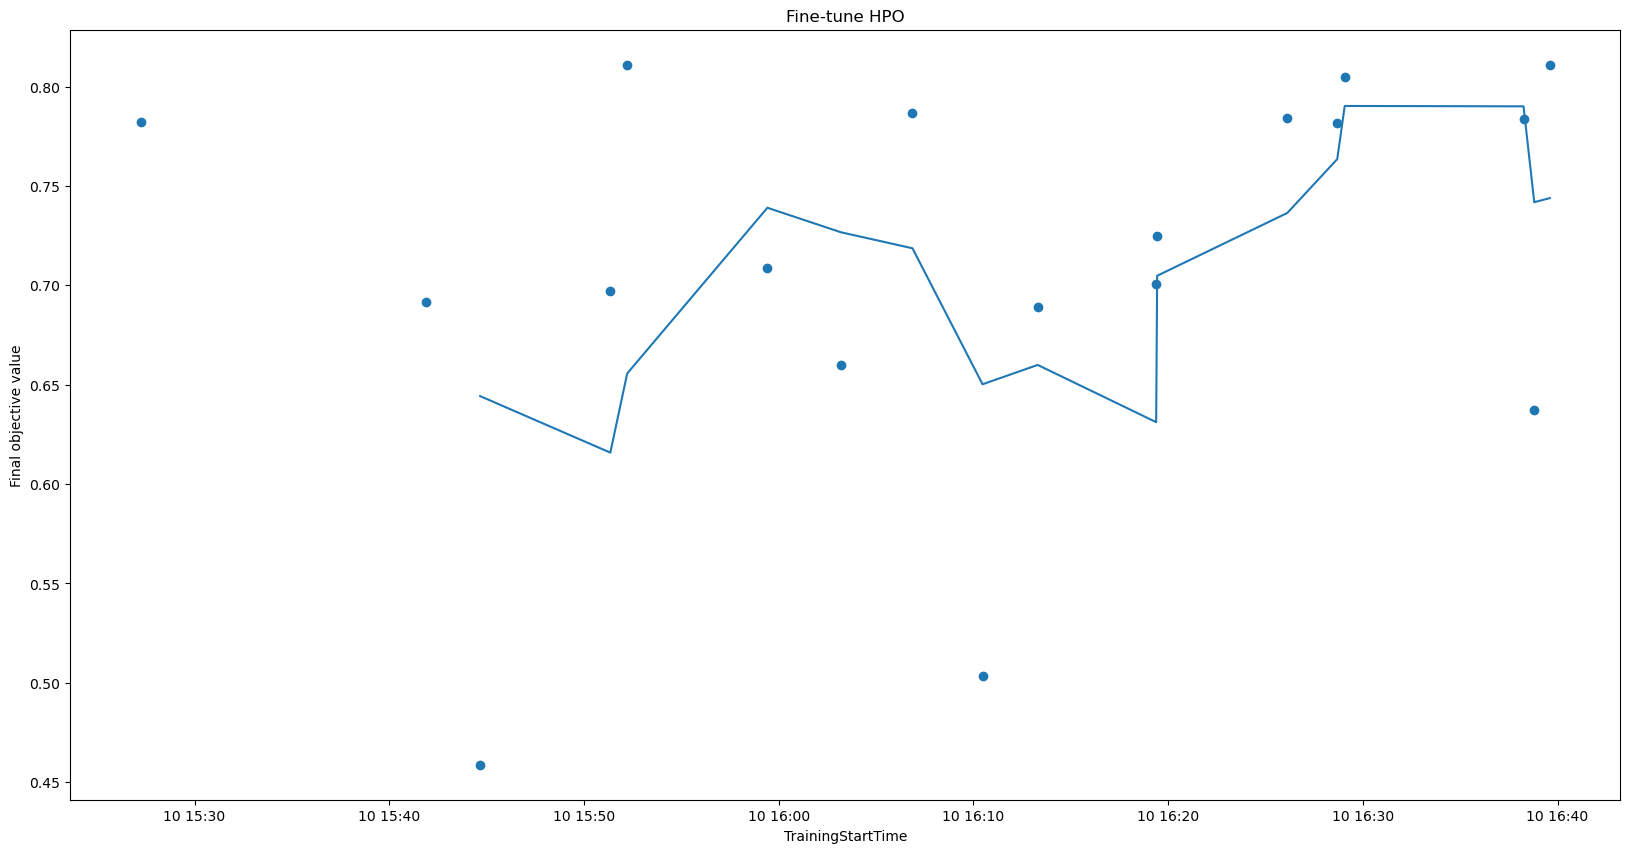

In [10]:
plt.figure(figsize=(20, 10))
# Remove missing values in TrainingStartTime
fine_tune_hpo_results.dropna(subset=['FinalObjectiveValue'], inplace=True)
# Sort by TrainingStartTime
fine_tune_hpo_results.sort_values('TrainingStartTime', inplace=True)
plt.scatter(fine_tune_hpo_results['TrainingStartTime'], fine_tune_hpo_results['FinalObjectiveValue'])
plt.plot(fine_tune_hpo_results['TrainingStartTime'], fine_tune_hpo_results['FinalObjectiveValue'].rolling(3).mean())
plt.xlabel('TrainingStartTime')
plt.ylabel('Final objective value')
plt.title('Fine-tune HPO')
plt.show();

## Hyperparameter Visualization

In [11]:
# List of hyperparameters
params = list(set(fine_tune_hpo_results.columns) - set(['TrainingJobName', 'TrainingJobStatus', 'TrainingStartTime', 'TrainingEndTime', 'TrainingElapsedTimeSeconds', 'FinalObjectiveValue']))
params.sort()

cat_params=['use_sample_weights', 'pretrained_name', 'pretrained_pooling', 'random_flip_mode', 'batch_size']
num_params = list(set(params) - set(cat_params))

# Visualizer
viz = custom_utils.TuningVisualizer(tune_data=fine_tune_hpo_results, cat_params=cat_params, num_params=num_params)
viz

### Parallel Coordiante 

Hyperarameters related to optimization:

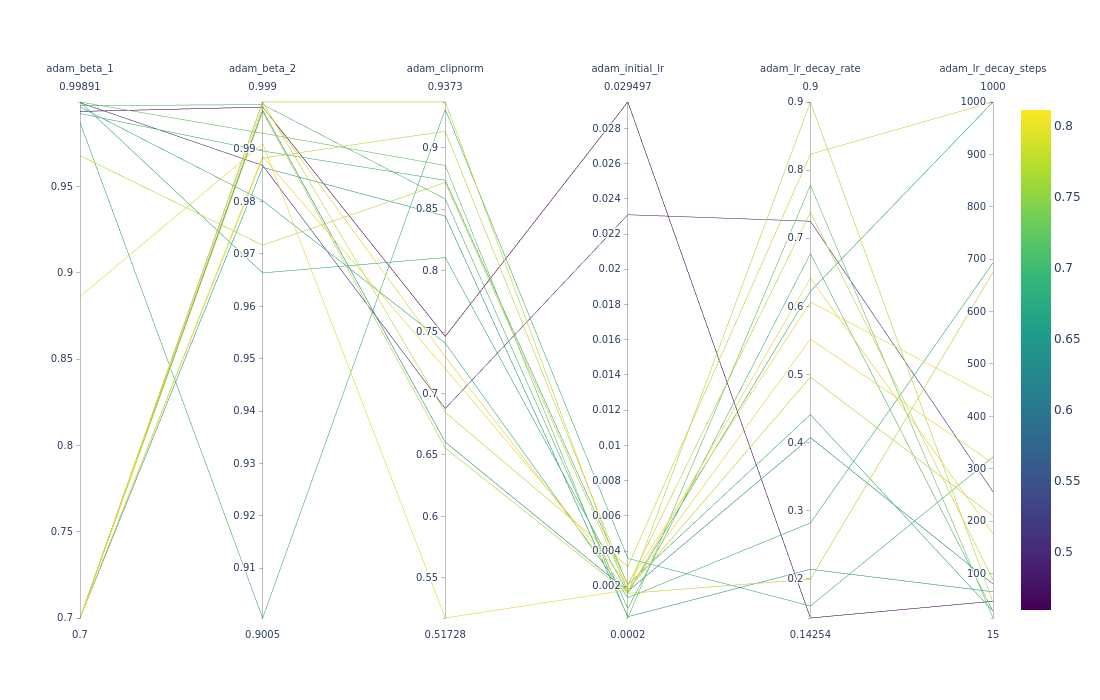

In [12]:
viz.plot_parallel_coordinate(columns=[param for param in params if match('^adam', param)], static=True, figsize=(1100, 700))

* Lower initial learning rate have higher objective values.

* Clipnorm and decay steps seem to be pretty random.

Dense layers hyperparameters:

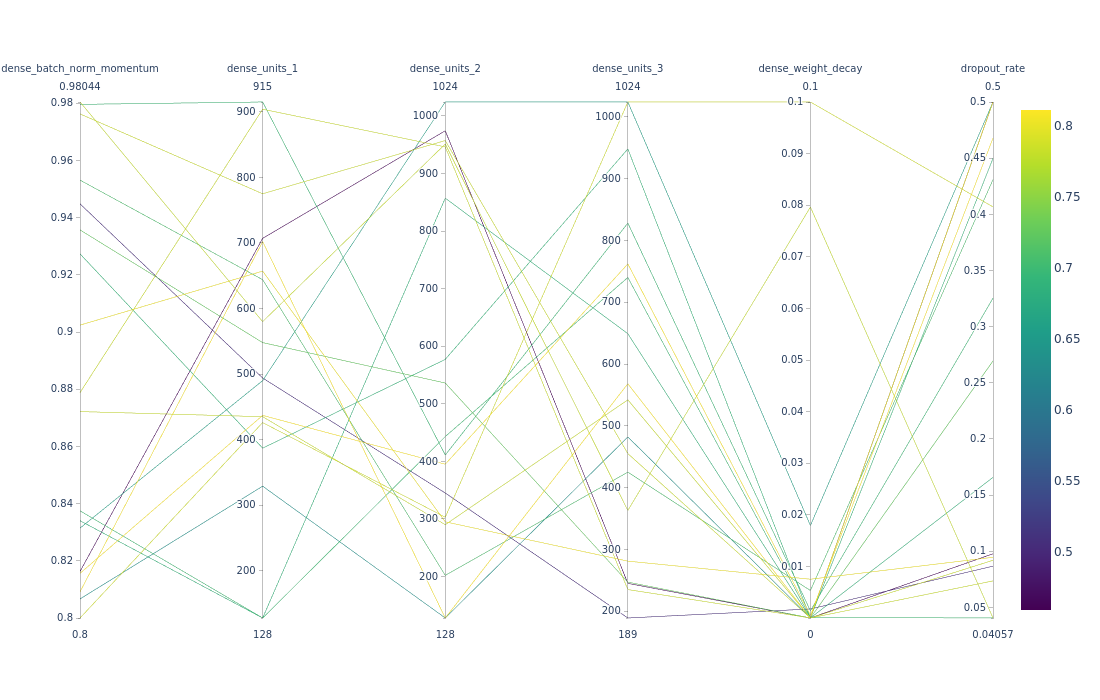

In [13]:
viz.plot_parallel_coordinate(columns=[param for param in params if match('^dense', param)] + ['dropout_rate'], static=True, figsize=(1100, 700))

Pretrained hyperparameters:

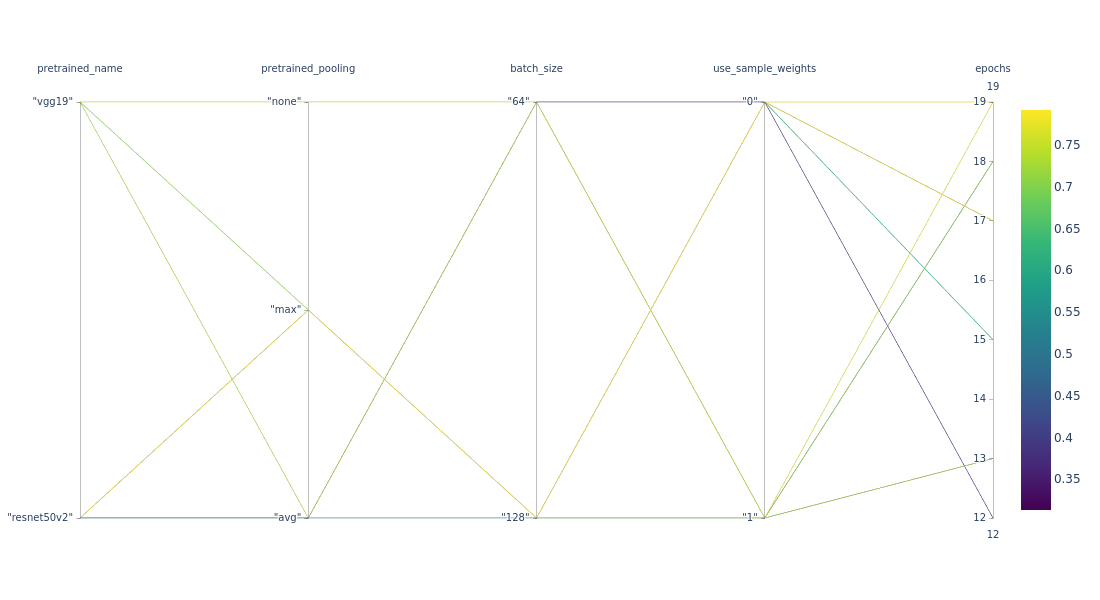

In [14]:
viz.plot_parallel_coordinate(columns=[param for param in params if match('^pretrained', param)] + ['batch_size', 'epochs', 'use_sample_weights'], static=True, figsize=(1100, 600))

Data augmentation hyperparameters:

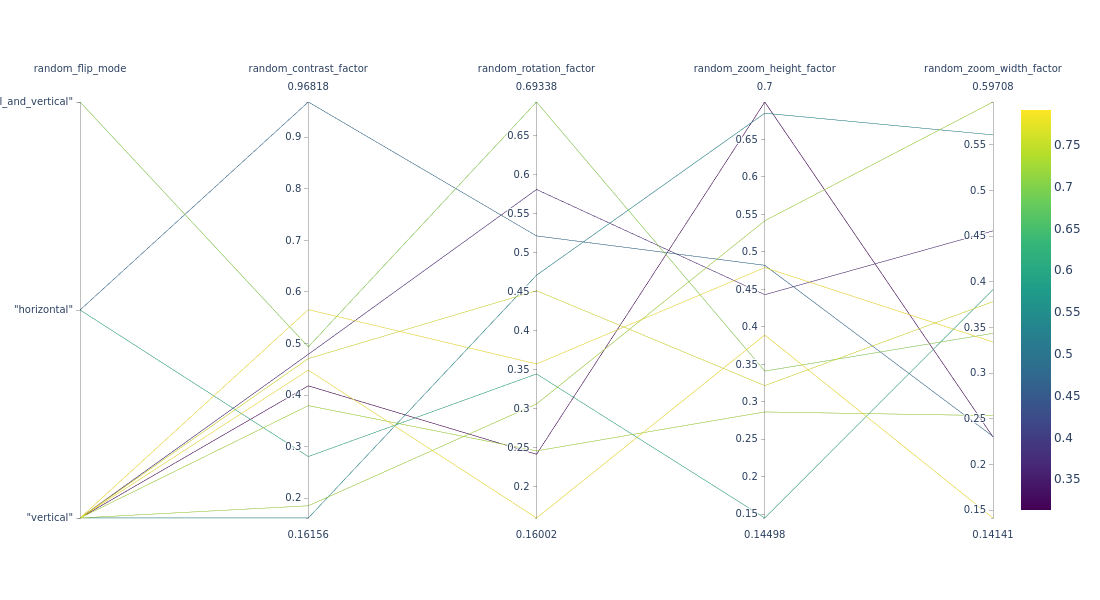

In [17]:
viz.plot_parallel_coordinate(columns=[param for param in params if match('^random', param)], static=True, figsize=(1100, 600))

## Inference

Deploy best model:

In [ ]:
best_model_name = sm_boto3.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=fine_tune_hpo_tuner.latest_tuning_job.name
)['BestTrainingJob']['TrainingJobName']

# Obtain s3 path to model artifacts
best_model_s3_path = sm_boto3.describe_training_job(
    TrainingJobName=best_model_name
)['ModelArtifacts']['S3ModelArtifacts']

print(f'Best model artifacts persisted at {best_model_s3_path}')

In [10]:
best_model = TensorFlowModel(
    model_data=config['best_model_s3_path'],
    role=role,
    framework_version=config['framework_version']
)

predictor = best_model.deploy(
    initial_instance_count=1,
    instance_type=baseline_config['instance_type'],
    endpoint_name=fine_tune_config['endpoint_name'] + '-' + strftime('%H-%M-%S', gmtime())
)

----!

Load train, validation, and test set:

In [6]:
X_train = np.load(io.BytesIO(s3.get_object(Bucket=config['s3_bucket'], Key=f'{config["s3_key"]}/input-data/train/X_train.npy')['Body'].read()))
X_val = np.load(io.BytesIO(s3.get_object(Bucket=config['s3_bucket'], Key=f'{config["s3_key"]}/input-data/val/X_val.npy')['Body'].read()))

X_train.shape, X_val.shape

((7130, 256, 256, 3), (1783, 256, 256, 3))

In [7]:
y_train = np.load(io.BytesIO(s3.get_object(Bucket=config['s3_bucket'], Key=f'{config["s3_key"]}/input-data/train/y_train.npy')['Body'].read()))
y_val = np.load(io.BytesIO(s3.get_object(Bucket=config['s3_bucket'], Key=f'{config["s3_key"]}/input-data/val/y_val.npy')['Body'].read()))

y_train.shape, y_val.shape

((7130,), (1783,))

In [8]:
X_test = np.load(io.BytesIO(s3.get_object(Bucket=config['s3_bucket'], Key=f'{config["s3_key"]}/input-data/test/X_test.npy')['Body'].read()))
y_test = np.load(io.BytesIO(s3.get_object(Bucket=config['s3_bucket'], Key=f'{config["s3_key"]}/input-data/test/y_test.npy')['Body'].read()))

X_test.shape, y_test.shape

((930, 256, 256, 3), (930,))

Make prediction in batches:

In [7]:
# Define the batch size
batch_size = 5

# Generate predictions in batches
val_num_instances = X_val.shape[0]
val_num_batches = (val_num_instances + batch_size - 1) // batch_size
train_num_instances = X_train.shape[0]
train_num_batches = (train_num_instances + batch_size - 1) // batch_size
test_num_instances = X_test.shape[0]
test_num_batches = (test_num_instances + batch_size - 1) // batch_size

Train:

In [13]:
train_predicted_probs = []
for i in tqdm(range(train_num_batches)):

    start_idx = i * batch_size
    end_idx = min(start_idx + batch_size, train_num_instances)
    batch = X_train[start_idx:end_idx]

    # Call the predict method of the TensorFlowPredictor object
    predictions = predictor.predict(batch)
    
    # Append the predicted labels to the list
    train_predicted_probs.append(predictions['predictions'])

# Concatenate the predicted labels from all batches (down the rows)
train_predicted_probs = np.concatenate(train_predicted_probs, axis=0)

train_predicted_probs

100%|██████████| 1426/1426 [34:30<00:00,  1.45s/it]


array([[1.51066093e-09, 2.37702170e-06, 9.84124660e-01, ...,
        1.54029101e-06, 1.58552881e-02, 1.14537863e-06],
       [2.46454787e-04, 4.20311606e-03, 2.66036559e-02, ...,
        5.66898525e-01, 3.62766266e-01, 9.40173413e-05],
       [1.70298488e-04, 9.82258469e-03, 2.61998735e-02, ...,
        1.70508791e-02, 9.37130153e-01, 6.63690000e-05],
       ...,
       [7.54295915e-09, 9.99936000e-01, 3.33072353e-06, ...,
        4.79563132e-05, 1.63657694e-06, 7.96202414e-07],
       [1.64960802e-03, 1.69871864e-03, 4.92862612e-02, ...,
        1.23062404e-02, 9.15046453e-01, 1.13641225e-04],
       [7.64585380e-03, 1.92453527e-07, 5.71531888e-09, ...,
        3.81339547e-08, 4.84395706e-08, 9.32890000e-06]])

Validation:

In [44]:
val_predicted_probs = []
for i in tqdm(range(val_num_batches)):

    start_idx = i * batch_size
    end_idx = min(start_idx + batch_size, val_num_instances)
    batch = X_val[start_idx:end_idx]
    
    # Call the predict method of the TensorFlowPredictor object
    predictions = predictor.predict(batch)
    
    # Append the predicted labels to the list
    val_predicted_probs.append(predictions['predictions'])

# Concatenate the predicted labels from all batches (down the rows)
val_predicted_probs = np.concatenate(val_predicted_probs, axis=0)

val_predicted_probs

100%|██████████| 357/357 [08:33<00:00,  1.44s/it]


array([[1.88064354e-04, 2.43267906e-03, 4.91444021e-01, ...,
        2.57897587e-03, 4.97904658e-01, 1.95811845e-05],
       [1.91507011e-03, 8.77105445e-02, 7.14811802e-01, ...,
        2.84650065e-02, 1.51204079e-01, 2.70694116e-04],
       [9.03190056e-08, 5.88437979e-05, 8.85593832e-01, ...,
        1.87549929e-04, 1.13868000e-01, 3.86915099e-06],
       ...,
       [1.74892900e-08, 9.99790251e-01, 3.84138584e-05, ...,
        1.07740278e-04, 1.23520431e-05, 3.75475338e-06],
       [3.12894315e-01, 2.22643154e-11, 3.88686852e-14, ...,
        9.51777199e-11, 2.99506269e-13, 1.03924572e-06],
       [3.50621849e-04, 3.84976098e-04, 2.87373527e-03, ...,
        5.78643918e-01, 3.37996542e-01, 5.04705058e-05]])

Test:

In [11]:
test_predicted_probs = []
for i in tqdm(range(test_num_batches)):

    start_idx = i * batch_size
    end_idx = min(start_idx + batch_size, test_num_instances)
    batch = X_test[start_idx:end_idx]
    
    # Call the predict method of the TensorFlowPredictor object
    predictions = predictor.predict(batch)
    
    # Append the predicted labels to the list
    test_predicted_probs.append(predictions['predictions'])

# Concatenate the predicted labels from all batches (down the rows)
test_predicted_probs = np.concatenate(test_predicted_probs, axis=0)

test_predicted_probs

100%|██████████| 186/186 [04:56<00:00,  1.59s/it]


array([[1.76270586e-03, 1.85437524e-03, 3.26218158e-02, ...,
        1.65229496e-02, 9.36566174e-01, 4.54750000e-05],
       [5.88873168e-04, 7.57031469e-03, 8.19611669e-01, ...,
        3.75152542e-03, 1.63723022e-01, 4.47938946e-05],
       [2.65023917e-01, 8.51052278e-07, 1.34151918e-07, ...,
        1.32966147e-06, 4.12810493e-07, 3.83590559e-05],
       ...,
       [1.89743564e-03, 9.43569280e-03, 2.75588542e-01, ...,
        1.96005423e-02, 6.46357596e-01, 1.62497687e-04],
       [6.60977326e-03, 4.50201698e-09, 9.36258848e-10, ...,
        8.15841528e-09, 3.95065625e-09, 1.75694515e-06],
       [3.27302550e-05, 9.86159384e-01, 9.90846474e-03, ...,
        1.32378272e-03, 6.26501220e-04, 6.14627061e-05]])

Write numpy probabilities matrices to s3:

In [12]:
s3.put_object(Bucket=config['s3_bucket'], Key=f'{config["s3_key"]}/output/val_predicted_probs.npy', Body=pickle.dumps(val_predicted_probs))
s3.put_object(Bucket=config['s3_bucket'], Key=f'{config["s3_key"]}/output/train_predicted_probs.npy', Body=pickle.dumps(train_predicted_probs))
s3.put_object(Bucket=config['s3_bucket'], Key=f'{config["s3_key"]}/output/test_predicted_probs.npy', Body=pickle.dumps(test_predicted_probs))

{'ResponseMetadata': {'RequestId': 'W9K2MSBQHCKVWJEF',
  'HostId': 'wIfJs1vkfF16yM40lmYlT2ZUDQnp4lrTsWmsHK/ry5/dfhlJFOWqMvIOWf0SXP6f0Rs+vSyMwnfAtYz3e9svLg==',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'wIfJs1vkfF16yM40lmYlT2ZUDQnp4lrTsWmsHK/ry5/dfhlJFOWqMvIOWf0SXP6f0Rs+vSyMwnfAtYz3e9svLg==',
   'x-amz-request-id': 'W9K2MSBQHCKVWJEF',
   'date': 'Wed, 12 Jul 2023 15:41:34 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"911a495db0ec179cf66c1f6d9439e919"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"911a495db0ec179cf66c1f6d9439e919"',
 'ServerSideEncryption': 'AES256'}

### Error Analysis

Load the predictions:

In [5]:
val_predicted_probs = pickle.loads(s3.get_object(Bucket=config['s3_bucket'], Key=f'{config["s3_key"]}/output/val_predicted_probs.npy')['Body'].read())
train_predicted_probs = pickle.loads(s3.get_object(Bucket=config['s3_bucket'], Key=f'{config["s3_key"]}/output/train_predicted_probs.npy')['Body'].read())
test_predicted_probs = pickle.loads(s3.get_object(Bucket=config['s3_bucket'], Key=f'{config["s3_key"]}/output/test_predicted_probs.npy')['Body'].read())

val_predicted_probs.shape, train_predicted_probs.shape, test_predicted_probs.shape

((1783, 9), (7130, 9), (930, 9))

In [15]:
error_analyzer = custom_utils.ErrorAnalyzer(
    y_true=y_train,
    images=X_train,
    y_pred=train_predicted_probs,
    label_mapping=config['class_label_map']
)

#### Backyard

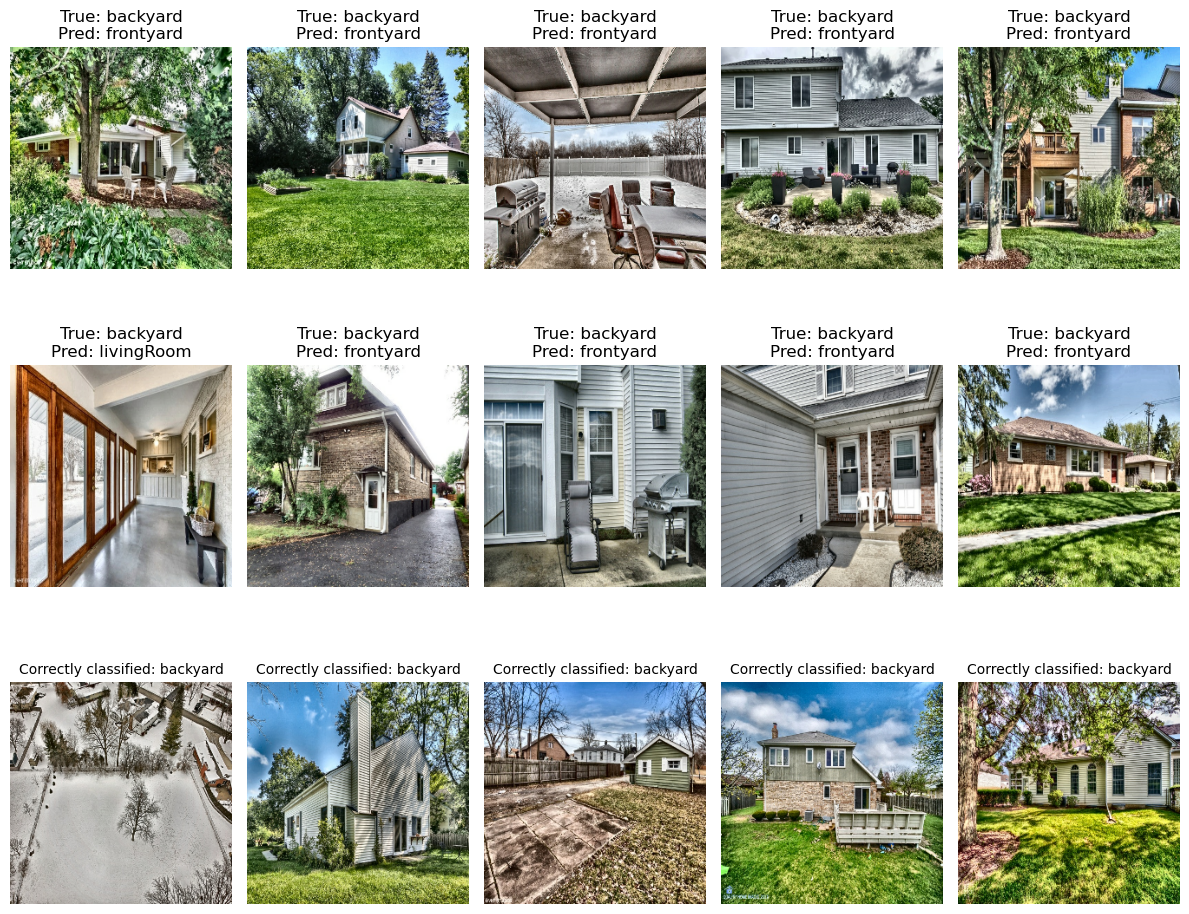

In [16]:
error_analyzer.plot_mis_clf(class_label='backyard', figsize=(12, 10));

* Many of the backyard and frontyards look very much alike, which can be hard to distinguish.

#### Bathroom

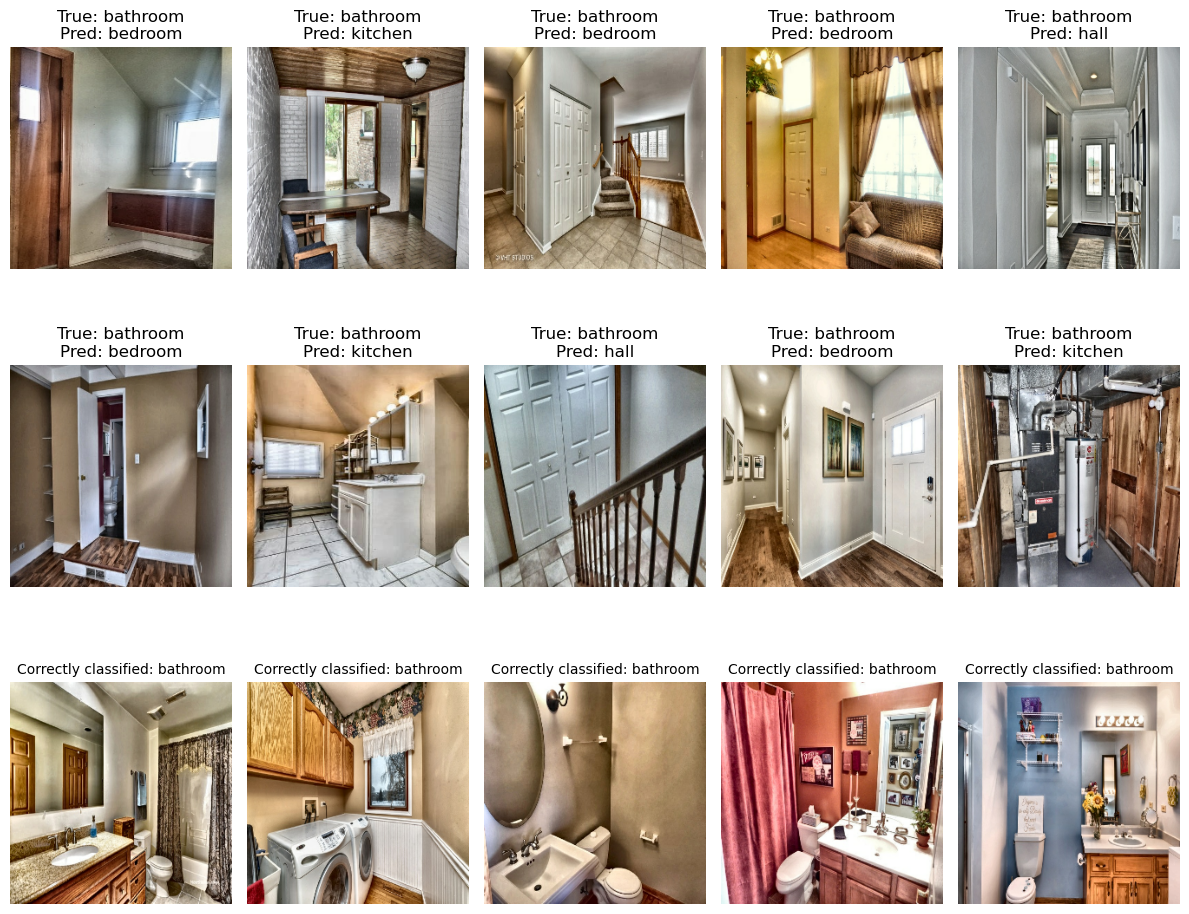

In [18]:
error_analyzer.plot_mis_clf(class_label='bathroom', figsize=(12, 10));

#### Dining Room

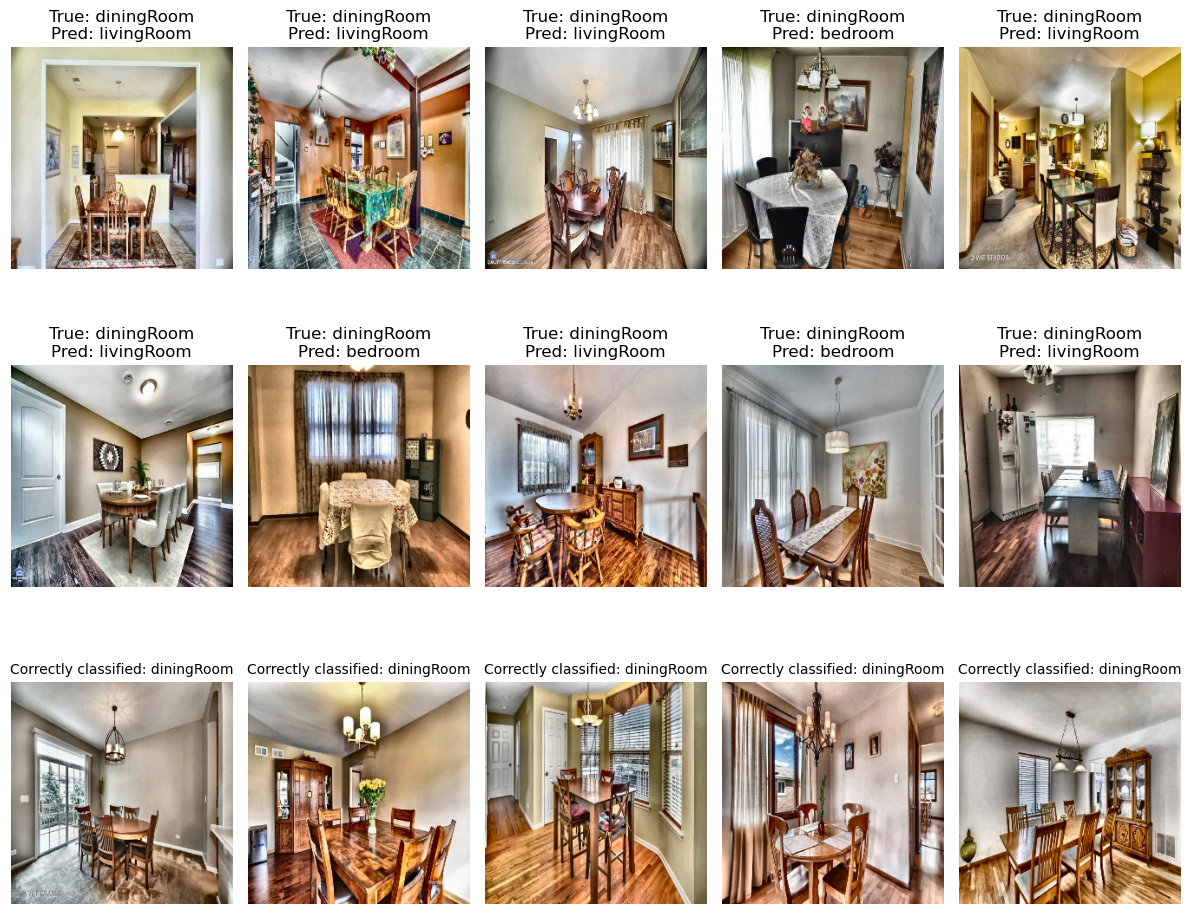

In [19]:
error_analyzer.plot_mis_clf(class_label='diningRoom', figsize=(12, 10));

#### Hall

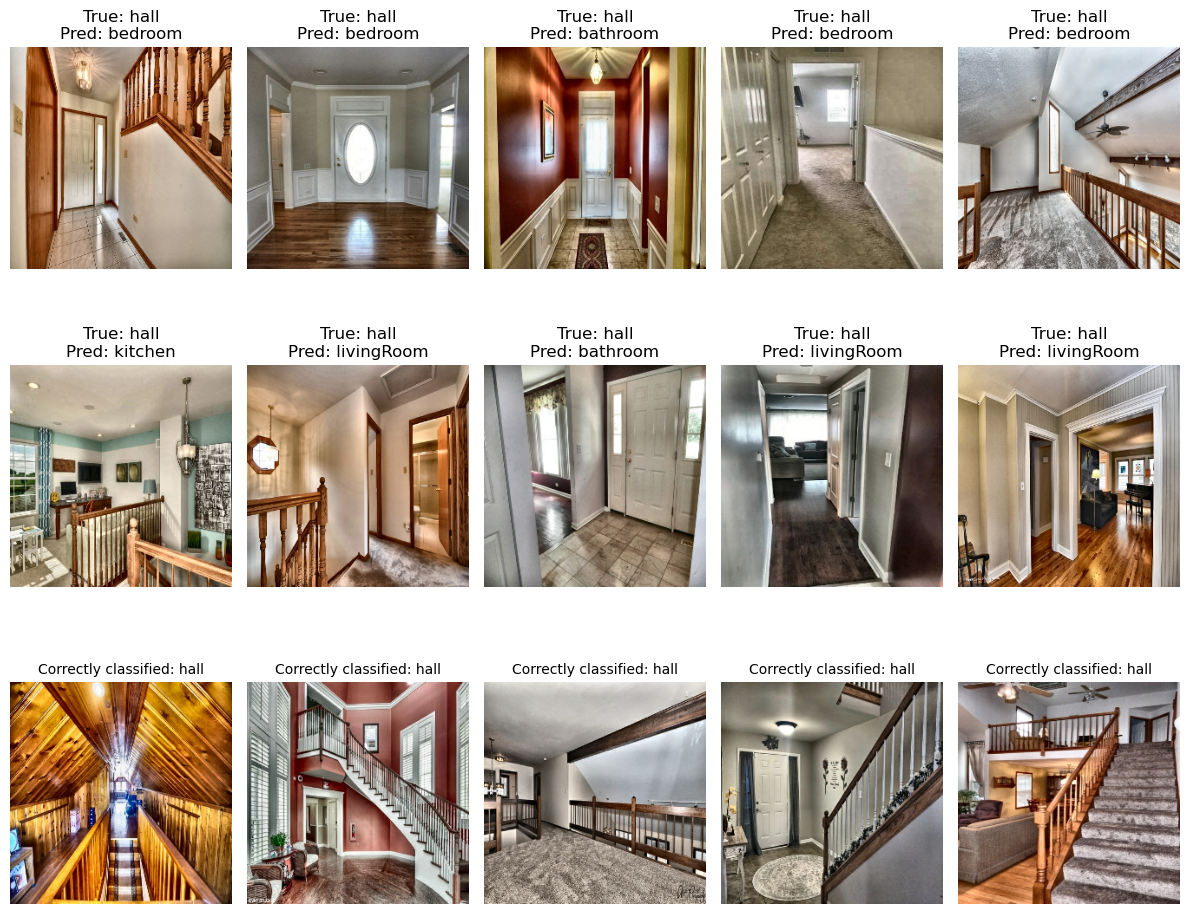

In [20]:
error_analyzer.plot_mis_clf(class_label='hall', figsize=(12, 10));

#### Plan

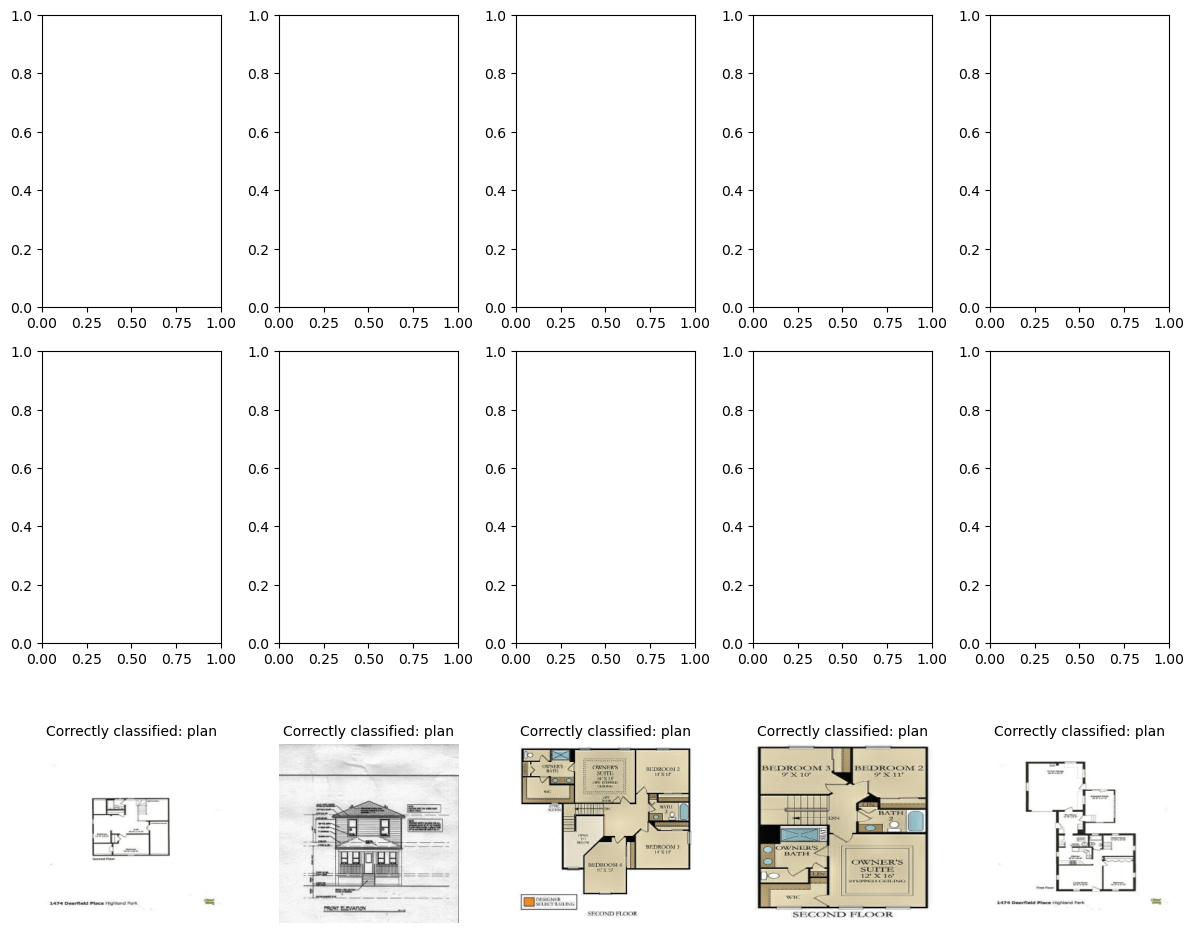

In [21]:
error_analyzer.plot_mis_clf(class_label='plan', figsize=(12, 10));

### Classification Report

In [28]:
config['class_label_map']

{'backyard': 0, 'bathroom': 1, 'bedroom': 2, 'diningRoom': 3, 'frontyard': 4, 'hall': 5, 'kitchen': 6, 'livingRoom': 7, 'plan': 8}

### Training

In [29]:
clf_report_train, agg_metrics_train = custom_utils.classification_report(y_train, train_predicted_probs.argmax(axis=1), labels=list(config['class_label_map']))

clf_report_train

precision  recall  specificity      f1  geometric_mean  \
backyard       0.8488  0.9233       0.9786  0.8845          0.9505   
bathroom       0.8650  0.9162       0.9772  0.8899          0.9462   
bedroom        0.7902  0.8720       0.9329  0.8291          0.9019   
diningRoom     0.6410  0.2137       0.9980  0.3205          0.4618   
frontyard      0.9085  0.8300       0.9908  0.8675          0.9069   
hall           0.6154  0.5854       0.9936  0.6000          0.7626   
kitchen        0.8868  0.8931       0.9846  0.8899          0.9377   
livingRoom     0.8375  0.7638       0.9501  0.7990          0.8519   
plan           0.9927  1.0000       0.9999  0.9963          0.9999   

            index_balanced_accuracy  support  
backyard                     0.8985    821.0  
bathroom                     0.8899    979.0  
bedroom                      0.8086   1602.0  
diningRoom                   0.1965    117.0  
frontyard                    0.8092    706.0  
hall                         0.5579    123.0  
kitchen                      0.8712    851.0  
livingRoom                   0.7122   1795.0  
plan                         0.9999    136.0

In [30]:
agg_metrics_train

{'avg_pre': 0.8408,
 'avg_rec': 0.8418,
 'avg_spe': 0.9639,
 'avg_f1': 0.8382,
 'avg_geo': 0.898,
 'avg_iba': 0.8026,
 'total_support': 7130}

### Validation

In [31]:
clf_report_val, agg_metrics_val = custom_utils.classification_report(y_val, val_predicted_probs.argmax(axis=1), labels=list(config['class_label_map']))

clf_report_val

precision  recall  specificity      f1  geometric_mean  \
backyard       0.8190  0.8829       0.9747  0.8498          0.9277   
bathroom       0.8617  0.8898       0.9772  0.8755          0.9325   
bedroom        0.7885  0.8200       0.9364  0.8039          0.8763   
diningRoom     0.4000  0.1379       0.9966  0.2051          0.3708   
frontyard      0.8563  0.8418       0.9844  0.8490          0.9103   
hall           0.4643  0.4194       0.9914  0.4407          0.6448   
kitchen        0.8651  0.8732       0.9815  0.8692          0.9258   
livingRoom     0.7708  0.7416       0.9258  0.7560          0.8286   
plan           1.0000  1.0000       1.0000  1.0000          1.0000   

            index_balanced_accuracy  support  
backyard                     0.8527    205.0  
bathroom                     0.8619    245.0  
bedroom                      0.7589    400.0  
diningRoom                   0.1257     29.0  
frontyard                    0.8169    177.0  
hall                         0.3920     31.0  
kitchen                      0.8478    213.0  
livingRoom                   0.6740    449.0  
plan                         1.0000     34.0

In [32]:
agg_metrics_val

{'avg_pre': 0.8056,
 'avg_rec': 0.811,
 'avg_spe': 0.957,
 'avg_f1': 0.8069,
 'avg_geo': 0.8773,
 'avg_iba': 0.7667,
 'total_support': 1783}

### Test

In [33]:
clf_report_test, agg_metrics_test = custom_utils.classification_report(y_test, test_predicted_probs.argmax(axis=1), labels=list(config['class_label_map']))

clf_report_test

precision  recall  specificity      f1  geometric_mean  \
backyard       0.8273  0.8273       0.9697  0.8273          0.8957   
bathroom       0.8188  0.8828       0.9688  0.8496          0.9248   
bedroom        0.7702  0.8158       0.9524  0.7923          0.8815   
diningRoom     0.6000  0.2000       0.9978  0.3000          0.4467   
frontyard      0.8837  0.8444       0.9811  0.8636          0.9102   
hall           0.4000  0.2000       0.9967  0.2667          0.4465   
kitchen        0.9294  0.8541       0.9839  0.8901          0.9167   
livingRoom     0.7024  0.7763       0.9357  0.7375          0.8523   
plan           0.9333  1.0000       0.9989  0.9655          0.9995   

            index_balanced_accuracy  support  
backyard                     0.7908    139.0  
bathroom                     0.8479    128.0  
bedroom                      0.7664    152.0  
diningRoom                   0.1836     15.0  
frontyard                    0.8172    135.0  
hall                         0.1835     10.0  
kitchen                      0.8294    185.0  
livingRoom                   0.7148    152.0  
plan                         0.9990     14.0

## Clean up

In [78]:
sm_boto3.delete_endpoint(EndpointName=predictor.endpoint_name)
sm_boto3.delete_endpoint_config(EndpointConfigName=predictor.endpoint_name)
sm_boto3.delete_model(ModelName=best_model.name)

{'ResponseMetadata': {'RequestId': 'a4004b2d-5559-4e12-a55e-12ad4009ff64',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'a4004b2d-5559-4e12-a55e-12ad4009ff64',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 12 Jul 2023 15:58:44 GMT'},
  'RetryAttempts': 0}}

In [79]:
sm_boto3.close()